In [ ]:
!pip install exeteracovid

In [1]:
"""
As a scientific data processing tool, Exetera provides the ability to handle underlying data storage automatically.
Hence, the first step is to specify the source dataset containing the data to process and the destination dataset 
that can write the results.
For more details: https://github.com/KCL-BMEIS/ExeTera/wiki/What-Is-ExeTera
"""
source_data = '/home/jie/bmeis/data/March31.hdf5'# the dataset from which the patient and assessment data is read
dest_data = '/home/jie/bmeis/data/result.hdf5' # the dataset to which the patient and assessment data is written

In [6]:
"""
This example shows how the merge operation works in Exetera. 
Assume there are two dataframes from the dataset, namely patients and assessments. We want to merge the patient 
information (age, weight_kg, and height_cm) from the patients dataframe to the assessments dataframe, by matching 
the 'id' field in patients with 'patient_id' field in assessments.
After merging, the patient information (age, weight_kg, and height_cm) will show up in the destination assessments 
dataframe, as well as the data storage utilized by destination assessments. 
More details: https://github.com/KCL-BMEIS/ExeTera/wiki/Intermediate-Examples#joining--merging
"""
from exetera.core.session import Session
from exetera.core import dataframe
from exetera.core.utils import Timer

# Everything starts creating a session. Using 'with' allows the datasets that we open to
# close automatically
with Session() as s:
    # You can open multiple datasets. It is generally wise to write intermediate results
    # to a separate dataset, rather than adding to the base dataset
    src = s.open_dataset(source_data, 'r', 'src')
    dest = s.open_dataset(dest_data, 'w', 'dest')

    # Get the patients and assessments dataframe from the source data, for convenience
    s_ptnts = src['patients']
    s_asmts = src['assessments']
    
    # Create the assessments group for the joined data
    d_asmts = dest.create_dataframe('assessments')

    # When you want to perform a join on a number of fields, it is useful to build a sequence of keys
    ptnt_keys = ('age', 'weight_kg', 'height_cm')

    # Get the tuple of fields that we want to join
    merge_sources = tuple(s_ptnts[k] for k in ptnt_keys)
    
    # Get a tuple of empty fields that we are writing the joined data to
    merge_sinks = tuple(s_ptnts[k].create_like(d_asmts, k) for k in ptnt_keys)
    
    # Get the patient 'id' field (primary key) and the assessment 'patient_id' field (foreign key)
    p_ids = s_ptnts['id']
    a_pids = s_asmts['patient_id']
    
    # Note, the merge may take a few minutes to complete!
    with Timer("merging"):
        s.ordered_merge_left(left_on=a_pids, right_on=p_ids, right_field_sources=merge_sources, left_field_sinks=merge_sinks, right_unique=True)

merging: completed in 2.349379301071167 seconds


ValueError: operands could not be broadcast together with shapes (63,) (101,) 

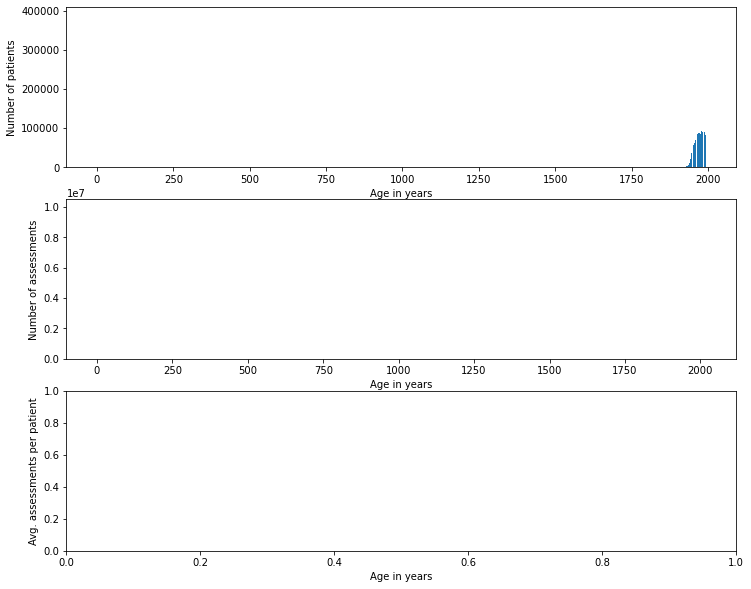

In [8]:
"""
As we have patient information associated with assessments from the merging section, now we can investigate the 
distribution of assessments against the patient info, such as age shown in the example below.
"""
import numpy as np
from matplotlib import pyplot as plt

# Start the Exetera session
with Session() as s:
    #Open the datasets
    src = s.open_dataset(source_data, 'r', 'src')
    dest = s.open_dataset(dest_data, 'r', 'dest')
    
    #Get the distribution of age in both the patient sample and the assessment sample
    p_age, p_count = np.unique(src['patients']['age'].data[:], return_counts=True)
    a_age, a_count = np.unique(dest['assessments']['age'].data[:], return_counts=True)
    
    #Plot the number of patients per each age in years;
    fig, ax = plt.subplots(3, 1, figsize=(12, 10))
    ax[0].set_xlabel("Age in years")
    ax[0].set_ylabel("Number of patients")
    ax[0].bar(p_age[:101], p_count[:101])
    
    #Plot the number of assessments per each age in years;
    ax[1].set_xlabel("Age in years")
    ax[1].set_ylabel("Number of assessments")
    ax[1].bar(a_age[:101], a_count[:101])
    
    #And plot the average number of assessments per patients by each age in years. 
    ax[2].set_xlabel("Age in years")
    ax[2].set_ylabel("Avg. assessments per patient")
    ax[2].bar(a_age[:101], a_count[:101] / p_count[:101])